In [94]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [95]:
audio_path = r'dataset/raw/2473663/2243804495.mp3'

In [96]:
sampling_rate = 44100

In [97]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sampling_rate = librosa.load(audio_path, sr = sampling_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

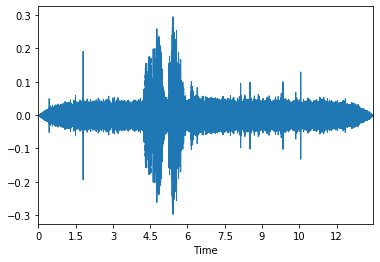

In [98]:
#plot with librosa
librosa.display.waveplot(time_series, sr=sampling_rate);

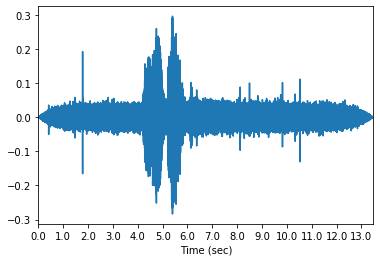

In [99]:
#plot with matplot 
fig, main_ax = plt.subplots()
main_ax.plot(time_series)
main_ax.set_xlim(left = 0, right = len(time_series))
main_ax.set_xticks(np.arange(0, len(time_series), step = sampling_rate))
main_ax.set_xticklabels(np.arange(0, len(time_series) / sampling_rate))
main_ax.set_xlabel('Time (sec)')
plt.show()

In [100]:
len(time_series)
#time_series

594432

In [101]:
librosa.feature.melspectrogram(y=time_series, sr=sampling_rate)

array([[5.40621381e-10, 8.58971672e-10, 2.91423063e-09, ...,
        3.03861381e-09, 6.52285448e-10, 1.12247456e-09],
       [3.40188455e-09, 1.61262437e-09, 2.92261504e-09, ...,
        1.83789572e-09, 1.12126830e-09, 9.74872294e-10],
       [2.17372542e-09, 3.01916003e-09, 2.96191982e-09, ...,
        3.18872972e-09, 8.68114025e-10, 2.27823899e-10],
       ...,
       [8.44999015e-10, 1.01223951e-09, 9.37421474e-10, ...,
        8.47488912e-10, 1.09092602e-09, 1.22256583e-09],
       [4.22600760e-10, 6.08540496e-10, 5.90740401e-10, ...,
        6.00857697e-10, 7.65023933e-10, 6.23007035e-10],
       [1.03545866e-10, 8.73571979e-11, 9.53773935e-11, ...,
        5.36480825e-11, 5.97626185e-11, 1.07600762e-10]], dtype=float32)

In [113]:
S = librosa.feature.melspectrogram(y=time_series, sr=sampling_rate, n_mels=128, fmax=9000)

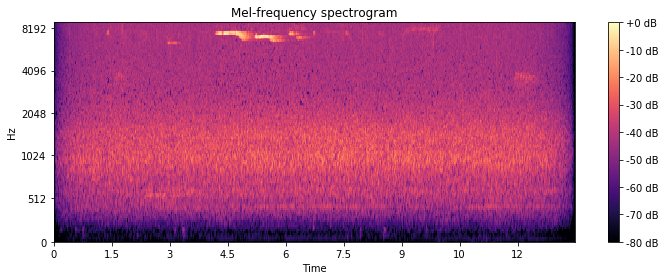

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sampling_rate,
                         fmax=9000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()